### Neural network

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.optimize as opt
from sklearn.metrics import classification_report
import matplotlib
%matplotlib inline

In [196]:
# load .mat file
# 5000 examples with each have 400 features
def load_data(path):
    data = sio.loadmat(path)
    y = data['y']
    y = y.reshape(y.shape[0])
    
    X = data['X']
    return X, y

In [197]:
X, y = load_data('ex3data1.mat')
X.shape, y.shape

((5000, 400), (5000,))

In [113]:
# plot image
def plot_an_image(image):
    fig, ax = plt.subplots(figsize=(1,1))
    ax.matshow(image.reshape(20,20), cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))

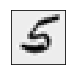

This should be 5


In [117]:
pick_one=np.random.randint(0, 5000)
plot_an_image(X[pick_one, :])
plt.show()
print(f"This should be {y[pick_one]}")

In [129]:
def plot_100_images(X):
    size = int(np.sqrt(X.shape[1]))
    
    sample_idx = np.random.choice(np.arange(X.shape[0]), 100)
    sample_images = X[sample_idx, :]
    
    fig, ax_array = plt.subplots(nrows=10, ncols=10, sharex=True, sharey=True, figsize=(8,8))
    
    for r in range(10):
        for c in range(10):
            ax_array[r, c].matshow(sample_images[10 * r + c].reshape(size, size), cmap = matplotlib.cm.binary)
            
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))            

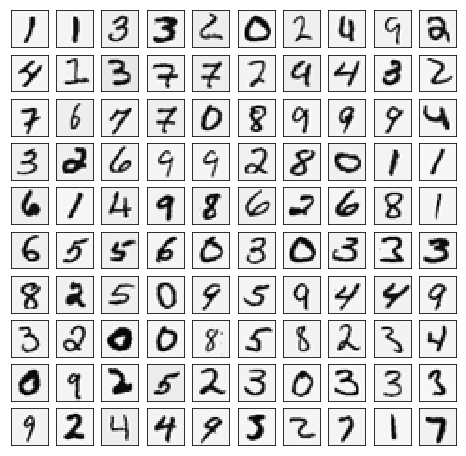

In [130]:
plot_100_images(X)
plt.show()

### Add theta_0 = 1 for each example

In [141]:
X = np.insert(X, 0, values=1, axis=1)

### 向量化标签 y
![标签](./向量化标签.png)

#### 标签化过程
---

In [76]:
t = np.array([1,2,3,4,5])
t.shape

(5,)

In [78]:
m = []
for k in range(1,t.shape[0]+1):
    m.append((t==k).astype(int))
m

[array([1, 0, 0, 0, 0]),
 array([0, 1, 0, 0, 0]),
 array([0, 0, 1, 0, 0]),
 array([0, 0, 0, 1, 0]),
 array([0, 0, 0, 0, 1])]

In [80]:
t1 = np.argmax(m, axis=1) + 1
t1

array([1, 2, 3, 4, 5], dtype=int64)

In [149]:
# 向量标签化转换
y_matrix = []

for k in range(1, 11):
    y_matrix.append((y==k).astype(int))
y_matrix = [y_matrix[-1]] + y_matrix[:-1]
y = np.array(y_matrix)

In [152]:
y.shape, X.shape

((10, 5000), (5000, 401))

---

### 1维模型

In [164]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def cost(theta, X, y):
    return np.mean(-y * np.log(sigmoid(X @ theta)) - (1 - y) * np.log(1-sigmoid(X @ theta)))

def gradient(theta, X, y):
    return (1 / len(X)) * X.T @(sigmoid(X @ theta) - y)

def regularized_cost(theta, X, y, lambda_=1):
    theta_1_to_n = theta[1:]
    regularized_term = (lambda_ / ( 2* len(X))) * np.power(theta_1_to_n, 2).sum()
    
    return cost(theta, X, y) + regularized_term

def regularized_gradient(theta, X, y, lambda_=1):
    theta_1_to_n = theta[1:]
    regularized_theta = (lambda_ / len(X)) * theta_1_to_n
    regularized_term = np.concatenate([np.array([0]), regularized_theta])
    
    return gradient(theta, X, y) + regularized_term

def logistic_regression(X, y, lambda_=1):
    theta = np.zeros(X.shape[1])
    result = opt.minimize(fun=regularized_cost,
                          x0=theta,
                          args=(X,y,lambda_),
                          method="TNC",
                          jac=regularized_gradient,
                          options={"disp": True}
    )
    best_theta = result.x
    return best_theta

def predict(x, theta):
    prob = sigmoid(x @ theta)
    return (prob>=.5).astype(int)

In [165]:
t0 = logistic_regression(X, y[0])

In [167]:
y_pred = predict(X, t0)
print(f"Accuracy={np.mean(y[0]==y_pred)}")

Accuracy=0.9974


### k维模型 

In [169]:
k_theta = np.array([logistic_regression(X, y[k]) for k in range(10)])
k_theta.shape

(10, 401)

### 预测
* think about the shape of k_theta, now you are making $X\times\theta^T$
> $(5000, 401) \times (10, 401).T = (5000, 10)$
* after that, you run sigmoid to get probabilities and for each row, you find the highest prob as the answer

In [173]:
np.set_printoptions(suppress=True)

In [170]:
prob_matrix = sigmoid(X @ k_theta.T)

In [177]:
prob_matrix.shape, prob_matrix

((5000, 10),
 array([[0.99577593, 0.        , 0.00053521, ..., 0.00006465, 0.00003911,
         0.00172173],
        [0.99834672, 0.0000001 , 0.00005621, ..., 0.00009682, 0.0000029 ,
         0.0000849 ],
        [0.99139946, 0.        , 0.00056762, ..., 0.00000654, 0.02655231,
         0.00197327],
        ...,
        [0.00000068, 0.04136364, 0.00322613, ..., 0.00012711, 0.00297417,
         0.70755243],
        [0.00001844, 0.00000013, 0.00000009, ..., 0.00164894, 0.06817339,
         0.861153  ],
        [0.02879484, 0.        , 0.00012935, ..., 0.36618717, 0.00497718,
         0.14822686]]))

In [285]:
# 向量标签化的逆过程
y_pred = np.argmax(prob_matrix, axis=1)
y_pred.shape, y_pred

((5000,), array([0, 0, 0, ..., 9, 9, 7], dtype=int64))

#### numpy的快速替换技巧

In [276]:
raw_X, raw_y = load_data('ex3data1.mat')

In [187]:
y_answer = raw_y.copy()
y_answer[y_answer==10] = 0
y.shape

(10, 5000)

In [188]:
print(classification_report(y_answer, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       500
           1       0.95      0.99      0.97       500
           2       0.95      0.92      0.93       500
           3       0.95      0.91      0.93       500
           4       0.95      0.95      0.95       500
           5       0.92      0.92      0.92       500
           6       0.97      0.98      0.97       500
           7       0.95      0.95      0.95       500
           8       0.93      0.92      0.92       500
           9       0.92      0.92      0.92       500

   micro avg       0.94      0.94      0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000



### 神经网络模型
![nn_model](./nn_model.png)

In [191]:
def load_weight(path):
    data = sio.loadmat(path)
    return data['Theta1'], data['Theta2']

In [192]:
theta1, theta2 = load_weight('ex3weights.mat')
theta1.shape, theta2.shape

((25, 401), (10, 26))

In [284]:
X, y = load_data('ex3data1.mat')
X = np.insert(X, 0, values=1, axis=1)
X.shape, y.shape

((5000, 401), (5000,))

### Forward  Propagation

In [287]:
a1 = X
z2 = X @ theta1.T
z2.shape

(5000, 25)

In [288]:
z2 = np.insert(z2, 0, values=1, axis=1)
a2 = sigmoid(z2)
a2.shape

(5000, 26)

In [289]:
z3 = a2 @ theta2.T
z3.shape

(5000, 10)

In [290]:
a3 = sigmoid(z3)
a3

array([[0.00013825, 0.0020554 , 0.00304012, ..., 0.00049102, 0.00774326,
        0.99622946],
       [0.00058776, 0.00285027, 0.00414688, ..., 0.00292311, 0.00235617,
        0.99619667],
       [0.00010868, 0.0038266 , 0.03058551, ..., 0.07514539, 0.0065704 ,
        0.93586278],
       ...,
       [0.06278247, 0.00450406, 0.03545109, ..., 0.0026367 , 0.68944816,
        0.00002744],
       [0.00101909, 0.00073436, 0.00037856, ..., 0.01456166, 0.97598976,
        0.00023337],
       [0.00005908, 0.00054172, 0.0000259 , ..., 0.00700508, 0.73281465,
        0.09166961]])

In [291]:
y_pred = np.argmax(a3, axis=1) + 1
y_pred.shape

(5000,)

### 准确率

In [292]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           1       0.97      0.98      0.97       500
           2       0.98      0.97      0.97       500
           3       0.98      0.96      0.97       500
           4       0.97      0.97      0.97       500
           5       0.98      0.98      0.98       500
           6       0.97      0.99      0.98       500
           7       0.98      0.97      0.97       500
           8       0.98      0.98      0.98       500
           9       0.97      0.96      0.96       500
          10       0.98      0.99      0.99       500

   micro avg       0.98      0.98      0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000

